In [2]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400

In [9]:
sql_pw='qwerty12'

In [6]:
def create_column_dictionary(text_file):
    '''
    Takes text file from User Guide to create library identifying locations of each feature.
    Returns pd.DataFrame
    The 'length' feature appears to be inconsistent
    '''

    import re
    import pandas as pd

    with open(text_file, 'r+') as f:
        ug = f.readlines()

    # Get field codes and corresponding columns
    field_list = [
        re.search(r'\b[0-9-]+\b\s\b[0-9]+\b\s\b[A-Z0-9_]{2,}\b',i).group() for i in ug if 
        re.search(r'\b[0-9-]+\b\s\b[0-9]+\b\s\b[A-Z0-9_]{2,}\b',i)
    ]

    # Place field numbers into DF
    field_code = pd.DataFrame(columns = ['start','end','length','field'])
    field_code['length'] = [re.split('\s',i)[1] for i in field_list]
    field_code['field'] = [re.split('\s',i)[2] for i in field_list]
    field_range = [re.split('\s',i)[0] for i in field_list]
    field_code['start'] = [re.split('-',i)[0] if re.search('-',i) else i for i in field_range]
    field_code['end'] = [re.split('-',i)[1] if re.search('-',i) else i for i in field_range]

    # Convert entry to numeric
    for i in ['start','end','length']:
        field_code[i] = pd.to_numeric(field_code[i])
    
    # Missing entries
    field_code_ug2018 = pd.DataFrame([[165,165,1,'F_FEDUC'], [280,281,2,'M_Ht_In'], 
                                      [292,294,3,'PWgt_R'], [299,301,3,'DWgt_R'], 
                                      [328,328,1,'f_RF_INFT'], [499,500,2,'OEGest_Comb'], 
                                      [501,502,2,'OEGest_R10'], [503,503,1,'OEGest_R3']], 
                                     columns = ['start','end','length','field'])
    
    field_code_ug2017 = pd.DataFrame([[280, 281, 2, 'M_Ht_In'],[292, 294, 3, 'PWgt_R'],[299, 301, 3, 'DWgt_R'],
                                      [328, 328, 1, 'f_RF_INFT'],[499, 500, 2, 'OEGest_Comb'],
                                      [501, 502, 2, 'OEGest_R10'],[503, 503, 1, 'OEGest_R3']],
                                     columns = ['start','end','length','field'])
    
    field_code_ug2016 = pd.DataFrame([[280, 281, 2, 'M_Ht_In'],[292, 294, 3, 'PWgt_R'],[299, 301, 3, 'DWgt_R'],
                                      [328, 328, 1, 'f_RF_INFT'],[499, 500, 2, 'OEGest_Comb'],
                                      [501, 502, 2, 'OEGest_R10'],[503, 503, 1, 'OEGest_R3']],
                                     columns = ['start','end','length','field'])
    
    field_code_ug2008 = pd.DataFrame([[609, 609, 1, 'F_LD_AUGMENT']],
                                     columns = ['start','end','length','field'])
    


    # Combine missing entries 
    if text_file.lower() == 'ug2018.txt':
        field_code = field_code.append(field_code_ug2018,ignore_index= True,sort = 'start')
        field_code = field_code.sort_values('start').reset_index().drop(columns='index')
    elif text_file.lower() == 'ug2017.txt':
        field_code = field_code.append(field_code_ug2017,ignore_index= True,sort = 'start')
        field_code = field_code.sort_values('start').reset_index().drop(columns='index')
    elif text_file.lower() == 'ug2016.txt':
        field_code = field_code.append(field_code_ug2016,ignore_index= True,sort = 'start')
        field_code = field_code.sort_values('start').reset_index().drop(columns='index')
    elif text_file.lower() == 'ug2008.txt':
        field_code = field_code.append(field_code_ug2008,ignore_index= True,sort = 'start')
        field_code = field_code.sort_values('start').reset_index().drop(columns='index')

    print(field_code.columns)
    

    # Find inconsistencies
    for i in range(0,len(field_code)-1):
        if field_code['end'][i] + 1 != field_code['start'][i+1]:
            print('check after: ', i,  field_code['field'][i], field_code['start'][i], '-', field_code['end'][i])
#         if field_code['end'][i] - field_code['start'][i] + 1 != field_code['length'][i]:
#             print('check range for: ', i,  field_code['field'][i], field_code['start'][i], '-', 
#                   field_code['end'][i], field_code['length'][i])

    

    return field_code

In [8]:
def no_more_filler(field_code):
    '''
    Looks for field that starts with 'FILLER' and drop the corresponding entry
    Returns shorter library pd.DataFrame
    '''
    import re
    
    field_code = field_code.loc[[False if re.search('^FILLER',i) else True for i in field_code['field']]]
    field_code.reset_index(inplace = True)
    field_code.drop(columns = ['index'], inplace = True)
    return field_code

In [5]:
def convert_to_csv(text_file, csv_file, column_dictionary):
    '''
    Pass fwf text, destination csv, column dictionary
    Read one line of the text file into python at a time
    Break each row apart into list and write onto csv
    '''

    import csv
    import time
    import re
    
    start_at = time.time()
    j=0
    c_dict = column_dictionary
    with open(csv_file,'w') as c:
        wc = csv.writer(c,quoting=csv.QUOTE_MINIMAL)
        
        # Write header
        wc.writerow(list(c_dict['field']))

        with open(text_file, 'r+') as f:
            for line in f:

#                 items = ["" if re.search(r'\A\s+\Z',line[c_dict['start'][i]-1 : c_dict['end'][i]]) 
#                          else line[c_dict['start'][i]-1 : c_dict['end'][i]] 
#                          for i in range(0,len(c_dict))]
                items = []
                for i in range(0,len(c_dict)):
#                     print(i)
                    from_here = c_dict['start'][i]-1
                    to_here = c_dict['end'][i]
                    if re.search(r'\A\s+\Z', line[from_here:to_here]):
                        items += [""]
                    else:
                        items += [line[from_here:to_here]]
#                     print(from_here, to_here)

                wc.writerow(items)
#         keep track of progress
                j += 1
                if j>20:
                    break
#                 if j%10000 == 0:
#                     print(j, time.time() - start_at)
    print('done at',j, 'in', time.time() - start_at)


In [12]:
#function to run simple SQL query from python
def create_table_from_SQL(user, database, password, query):
    '''
    - A function that returns a pandas dataframe from a SQL query in python
    ---------------
    - user: user for your local SQL connection in string format
    - database: schema name where your database is stored in string format
    - password: password to access your local SQL connection in string format
    - query: SQL query in string format; enclose with double quotes and use single quotes
    to designate VARCHAR values within queries; use schema_name.table_name after FROM statement
    '''
    import mysql.connector
    cnx = mysql.connector.connect(user=user, database=database, password=password)
    cursor = cnx.cursor()
    query = query
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall())
    df.columns = cursor.column_names
    return df

In [5]:
#modified version of Bettina's function which creates downsampled dataset for specific defects
#vs overall NICU admissions

def downsample_df (df, variable):

    '''
    Remove undefined information on defect presence admissions (defect == 'U'),
    create a binary target vector, and create a "balanced" dataframe
    with all defect cases and matching numbers of randomly selected non-defect cases.
    --------------------
    df: full dataframe
    variable: variable or defect of interest in string format
    '''

    # remove unknown class from df
    df_no_unknown = df[df[variable].isin(['Y', 'N'])]

    # Create binary target vector, NICU = yes classified as class 0
    df_y_n = pd.DataFrame(np.where((df_no_unknown[variable] == 'Y'), 0, 1))

    # Get indicies of each class' observations
    index_class0 = np.where(df_y_n == 0)[0]
    index_class1 = np.where(df_y_n == 1)[0]

    # Get numbers of observations in class 0
    n_class0 = len(index_class0)

    # Randomly sample the same number of observations from class 1 as in class 0, without replacement
    np.random.seed(0)
    index_class1_downsampled = np.random.choice(index_class1, size=n_class0, replace=False)

    # Create dataframes for NICU and downsampled non-NICU
    df_defect = df_no_unknown.iloc[index_class0]
    df_adj_NONdefect = df_no_unknown.iloc[index_class1_downsampled]

    # Append into 1 dataframe
    df_downsampled = df_defect.append(df_adj_NONdefect)

    return df_downsampled

In [7]:
# function to split out holdout test set
def split_sets(dataframe, seed, test_prop=0.1): 
    '''
    - A function that splits specifically a dataframe into a train and test portion
    - Requires multiple assignment: train, test
    ---------------
    - dataframe: dataframe to be split
    - seed: set seed for reproducability
    - test_prop: takes a float - proportion of dataframe that should be allocated to the test set
    '''

    np.random.seed(seed)
    testIdxes = np.random.choice(range(0,dataframe.shape[0]), size=round(dataframe.shape[0]*test_prop), replace=False)
    trainIdxes = list(set(range(0,dataframe.shape[0])) - set(testIdxes))

    train = dataframe.iloc[trainIdxes,:]
    test  = dataframe.iloc[testIdxes,:]
    
    return train, test

In [26]:
# begin dictionary of columns to analyze for CCHD - includes pre-pregnancy and gestational features
# features re: delivery and labor are not useful for this use case
variables = {'nominal_categorical':['MBSTATE_REC','MRACEHISP','MAR_P','DMAR','MEDUC','FRACEHISP',\
                                    'FEDUC','WIC','RF_PDIAB','RF_GDIAB','RF_PHYPE','RF_GHYPE',\
                                    'RF_EHYPE','RF_PPTERM','RF_INFTR','RF_FEDRG','RF_ARTEC','RF_CESAR',\
                                  'IP_GON','IP_SYPH','IP_CHLAM','IP_HEPB','IP_HEPC', 'PAY', 'SEX'],\
           'ordinal_categorical':['PRECARE', 'DOB_MM'],\
           'continuous':['MAGER', 'FAGECOMB','PRIORTERM','PRIORLIVE','PRIORDEAD','LBO_REC','TBO_REC',\
                         'ILLB_R','ILOP_R','ILP_R','PREVIS','CIG_0','CIG_1','CIG_2','CIG_3','M_Ht_In','BMI',\
                         'WTGAIN','RF_CESARN','OEGest_Comb'],\
            'target':['CA_CCHD']}

In [10]:
#pull selected variables from 2016-2018 databases in SQL and append to a single dataframe
query18 = "SELECT MBSTATE_REC,MRACEHISP,MAR_P,DMAR,MEDUC,FRACEHISP,FEDUC,WIC,RF_PDIAB,RF_GDIAB,RF_PHYPE,\
                RF_GHYPE,RF_EHYPE,RF_PPTERM,RF_INFTR,RF_FEDRG,RF_ARTEC,RF_CESAR,IP_GON,IP_SYPH,IP_CHLAM,\
                IP_HEPB,IP_HEPC,PAY,SEX,PRECARE,DOB_MM,MAGER,FAGECOMB,PRIORTERM,PRIORLIVE,PRIORDEAD,\
                LBO_REC,TBO_REC,ILLB_R,ILOP_R,ILP_R,PREVIS,CIG_0,CIG_1,CIG_2,CIG_3,M_Ht_In,BMI,WTGAIN,\
                RF_CESARN,OEGest_Comb,CA_CCHD\
         FROM cdc.us2018"

query17 = "SELECT MBSTATE_REC,MRACEHISP,MAR_P,DMAR,MEDUC,FRACEHISP,FEDUC,WIC,RF_PDIAB,RF_GDIAB,RF_PHYPE,\
                RF_GHYPE,RF_EHYPE,RF_PPTERM,RF_INFTR,RF_FEDRG,RF_ARTEC,RF_CESAR,IP_GON,IP_SYPH,IP_CHLAM,\
                IP_HEPB,IP_HEPC,PAY,SEX,PRECARE,DOB_MM,MAGER,FAGECOMB,PRIORTERM,PRIORLIVE,PRIORDEAD,\
                LBO_REC,TBO_REC,ILLB_R,ILOP_R,ILP_R,PREVIS,CIG_0,CIG_1,CIG_2,CIG_3,M_Ht_In,BMI,WTGAIN,\
                RF_CESARN,OEGest_Comb,CA_CCHD\
         FROM cdc.us2017"

query16 = "SELECT MBSTATE_REC,MRACEHISP,MAR_P,DMAR,MEDUC,FRACEHISP,FEDUC,WIC,RF_PDIAB,RF_GDIAB,RF_PHYPE,\
                RF_GHYPE,RF_EHYPE,RF_PPTERM,RF_INFTR,RF_FEDRG,RF_ARTEC,RF_CESAR,IP_GON,IP_SYPH,IP_CHLAM,\
                IP_HEPB,IP_HEPC,PAY,SEX,PRECARE,DOB_MM,MAGER,FAGECOMB,PRIORTERM,PRIORLIVE,PRIORDEAD,\
                LBO_REC,TBO_REC,ILLB_R,ILOP_R,ILP_R,PREVIS,CIG_0,CIG_1,CIG_2,CIG_3,M_Ht_In,BMI,WTGAIN,\
                RF_CESARN,OEGest_Comb,CA_CCHD\
         FROM cdc.us2016"


In [32]:
queries = [query18, query17, query16]
            
cchd = pd.DataFrame()
test_cchd = pd.DataFrame()

for query in queries:
    temp = create_table_from_SQL('root','cdc',sql_pw, query)
    train, test = split_sets(temp, 0, test_prop=0.1)
    train = downsample_df(train, 'CA_CCHD')
    cchd = cchd.append(train)  
    test_cchd = test_cchd.append(test)

In [23]:
def mlp_convert_cont_floats(df):
    #convert continuous variables to float
    #update to split out ordinal categorical separately
    for x in variables['continuous']:
        df[x]=df[x].astype('float')
    return df

def mlp_convert_nom_cat(df):
    #convert nominal categorical variables to category
    for x in variables['nominal_categorical']:
        df[x]=df[x].astype('category')
    return df

def mlp_convert_ord_cat(df):
    #convert ordinal categorical variables
    df.DOB_MM = df.DOB_MM.astype('category')
    df.PRECARE = df.PRECARE.astype('float')
    return df

def mlp_fill_MAR_blanks(df):
    #change true nulls to fit missingness definitions already in the dataset
    df.isnull().sum()
    df.MAR_P = df.MAR_P.fillna(value='U')
#     df.DMAR = df.DMAR.fillna(value=9)
    df.DMAR.replace('',9, inplace=True) # need to take care of 1 vs '1'
    df.DMAR.replace('1',1, inplace=True)
    df.DMAR.replace('2',2, inplace=True)
    return df

def mlp_reassign_FRACE(df):
    #combine FRACEHISP unknowns columns
    df.FRACEHISP = df.FRACEHISP.replace(8,9)
    return df

def mlp_reassign_X_NA(df):
    #assign 'X' to 'N' for RF_FEDRG RF_ARTEC and 'Y' for MAR_P since paternity assumed for married
    for x in ['RF_FEDRG', 'RF_ARTEC']:
        df[x].replace('X','N', inplace=True)
    df.MAR_P.replace('X','Y', inplace=True)
    return df

def mlp_reassign_ILs(df):
    #assign 888 to mean for ILLB_R and ILP_R
    for x in ['ILLB_R', 'ILP_R', 'ILOP_R']:
        df[x].replace(888,df.MAGER*12, inplace=True)
    return df

def mlp_all_of_the_above(df):
    df = mlp_fill_MAR_blanks(df)
    df = mlp_reassign_FRACE(df)
    df = mlp_reassign_X_NA(df)
    df = mlp_reassign_ILs(df)
    df = mlp_convert_cont_floats(df)
    df = mlp_convert_nom_cat(df)
    df = mlp_convert_ord_cat(df)
    return df

In [80]:
#create missingness types:
missing_dict = {'cont9': ['LBO_REC', 'TBO_REC'],\
                'cont99': ['FAGECOMB', 'PRIORTERM','PRIORLIVE', 'PRIORDEAD', 'PRECARE', 'PREVIS',\
                         'CIG_0', 'CIG_1', 'CIG_2', 'CIG_3', 'M_Ht_In', 'WTGAIN', 'RF_CESARN', 'OEGest_Comb'],\
                'cont999':['ILLB_R', 'ILP_R', 'ILOP_R'],\
                'cont99.9': ['BMI'],\
                'cat3': ['MBSTATE_REC'],\
                'cat8': ['MRACEHISP'],\
                'cat9': ['MEDUC', 'FEDUC', 'PAY', 'FRACEHISP', 'DMAR'],\
                'catU': ['WIC','RF_PDIAB','RF_GDIAB','RF_PHYPE',\
                        'RF_GHYPE','RF_EHYPE','RF_PPTERM','RF_INFTR','RF_FEDRG','RF_ARTEC','RF_CESAR','IP_GON',\
                        'IP_SYPH','IP_CHLAM','IP_HEPB','IP_HEPC', 'MAR_P']}
missing_vals = [9,99,999,99.9,3,8,9,'U']

#create table of missingness proportions
missing_props = pd.DataFrame()
for i in range(0,len(missing_vals)):
    temp = cchd.groupby('CA_CCHD')[missing_dict[list(missing_dict.keys())[i]]].apply\
    (lambda x: np.sum(x==missing_vals[i])/(cchd.shape[0]/2))
    missing_props = pd.concat([missing_props, temp], axis=1)   

#create lists of variables with high missingness vs. low missingness
large_miss = list(missing_props.columns[missing_props.apply(lambda x: sum(x)>0.1, axis=0)])
small_miss = list(missing_props.columns[missing_props.apply(lambda x: sum(x)<0.1, axis=0)])

#sort low missingness categorical variables into types
small_cats = {'cat3': [], 'cat8': [], 'cat9': [], 'catU': []}

for var in small_miss:
    if var in missing_dict['cat3']:
        small_cats['cat3'].append(var) 
    elif var in missing_dict['cat8']:
        small_cats['cat8'].append(var)
    elif var in missing_dict['cat9']:
        small_cats['cat9'].append(var)
    elif var in missing_dict['catU']:
        small_cats['catU'].append(var)    


#sort low missingness continuous variables
small_conts = {'cont9': [], 'cont99': [], 'cont999': [], 'cont99.9': []}

for var in small_miss:
    if var in missing_dict['cont9']:
        small_conts['cont9'].append(var) 
    elif var in missing_dict['cont99']:
        small_conts['cont99'].append(var)
    elif var in missing_dict['cont999']:
        small_conts['cont999'].append(var)
    elif var in missing_dict['cont99.9']:
        small_conts['cont99.9'].append(var)


In [197]:
def mlp_impute_s_cat(df,df_w):
    #mode imputation of categoricals with low missingness
    small_vals = [3,8,9,'U']
    for i in range(0, len(small_vals)):
        temp_lis = small_cats[list(small_cats.keys())[i]]
        for x in temp_lis:
            major_cat = df_w[x].value_counts().sort_values(ascending=False).index[0]
            df[x]=df[x].replace(small_vals[i],major_cat)
    return df

def mlp_impute_s_num(df,df_w):
    #median imputation of categoricals with low missingness
    #statistical significance of relationship with target imnproves on variable by variable basis after 
    #median imputation
    csmall_vals = [9,99,999,99.9]
    for i in range(0, len(csmall_vals)):
        temp_lis = small_conts[list(small_conts.keys())[i]]
        for x in temp_lis:
            df[x]=df[x].replace(csmall_vals[i],df_w[x].median())
    return df


def binarize9(x):
    if x==9:
        return 1
    else:
        return 0
    
def binarize99(x):
    if x==99:
        return 1
    else:
        return 0

def binarize999(x):
    if x==999:
        return 1
    else:
        return 0

    
def mlp_impute_FAGECOMB(df,df_w):
    #Impute FAGECOMB missing vals and store whether column was imputed    
    df['FAGECOMB_IMP'] = df.FAGECOMB.apply(lambda x: binarize99(x))
    df.FAGECOMB.replace(99, df_w.FAGECOMB.median(),inplace = True)
    return df

def mlp_impute_ILPs(df,df_w):
    #Impute ILOP_R and ILP_R missing vals and store whether column was imputed
    for x in ['ILOP_R', 'ILP_R']:
        df[x+'_IMP'] = df[x].apply(lambda x: binarize999(x))
    for x in ['ILOP_R', 'ILP_R']:
        df[x].replace(999,df_w[x].median(), inplace=True)
    return df

def mlp_impute_FRACE_ED(df,df_w):
    #Impute FRACEHISP and FEDUC missing vals and store whether column was imputed
    for x in ['FRACEHISP', 'FEDUC']:
        df[x+'_IMP'] = df[x].apply(lambda x: binarize9(x))
    for x in ['FRACEHISP', 'FEDUC']:
        df[x].replace(9,df_w[x].mode()[0], inplace=True)
    return df

def mlp_all_imputes(df,df_w):
    df = mlp_impute_s_cat(df,df_w)
    df = mlp_impute_s_num(df,df_w)
    df = mlp_impute_FAGECOMB(df,df_w)
    df = mlp_impute_ILPs(df,df_w)
    df = mlp_impute_FRACE_ED(df,df_w)
    df['lrg_miss_imp'] = df.FAGECOMB_IMP | df.ILOP_R_IMP | df.FRACEHISP_IMP | df.FEDUC_IMP
    df.drop(columns = imputed_col, inplace=True)
    return df


In [15]:

#dummfiy columns

def dummify_columns(dataframe,var_list):
    '''
    dummifies a columns, merges with the dataframe, and drops the non-dummified column
    ------------
    dataframe: full dataframe
    variable: column name as string
    '''
    for vr in var_list:
        dummified_feature = pd.get_dummies(dataframe[vr], prefix=vr,drop_first=True,prefix_sep='__')
        dataframe = pd.concat([dataframe,dummified_feature],axis=1,sort=False)
    dataframe.drop(columns = var_list, inplace = True)
    return dataframe

In [ ]:
def add_random_column_to_df (dataframe):
    import random
    mylist = []
    for i in range(0,dsample.shape[0]):
        x = random.randint(1,1000)
        mylist.append(x)
    dataframe['RANDOM'] = mylist

    return dataframe

In [160]:
cchd = pd.read_csv('cchd_all_imputed.csv')

In [161]:
cchd.groupby('DMAR').size()#.unique()

DMAR
1.0    7334
2.0    4456
dtype: int64

In [81]:
# cchd = mlp_all_of_the_above(cchd)
cchd = mlp_all_imputes(cchd,cchd)

In [162]:
# cchd = mlp_fill_MAR_blanks(cchd)
cchd = mlp_convert_cont_floats(cchd)
cchd = mlp_convert_nom_cat(cchd)
cchd = mlp_convert_ord_cat(cchd)

In [163]:
for x in variables['nominal_categorical']:
    try:
        cchd[x]=cchd[x].astype('int')
    except:
        pass

In [164]:
#find variables to dummify
to_dummify = list(cchd.columns[(cchd.dtypes=='category')|(cchd.dtypes=='object')])

In [165]:
import re
imputed_col = list(filter(lambda i: re.search('_IMP',i), cchd.columns))

In [190]:
imputed_col

['FAGECOMB_IMP', 'ILOP_R_IMP', 'ILP_R_IMP', 'FRACEHISP_IMP', 'FEDUC_IMP']

In [196]:
cchd['lrg_miss_imp']= cchd.FAGECOMB_IMP | cchd.ILOP_R_IMP | cchd.FRACEHISP_IMP | cchd.FEDUC_IMP
cchd.drop(columns = imputed_col, inplace=True)

AttributeError: 'DataFrame' object has no attribute 'FAGECOMB_IMP'

In [188]:
cont_vars

['M_Ht_In',
 'FEDUC',
 'ILLB_R',
 'PRIORDEAD',
 'PREVIS',
 'PRECARE',
 'OEGest_Comb',
 'WTGAIN',
 'MEDUC',
 'PAY',
 'RF_CESARN',
 'ILOP_R',
 'MRACEHISP',
 'CIG_0',
 'BMI',
 'FRACEHISP',
 'PRIORLIVE',
 'MBSTATE_REC',
 'CIG_1',
 'MAGER',
 'FAGECOMB',
 'Unnamed: 0',
 'ILP_R',
 'PRIORTERM',
 'DMAR']

In [181]:
import itertools
# for trials in 
qa = itertools.combinations(['CIG_0','CIG_1','CIG_2','CIG_3'],2)
list(list(qa)[1])

['CIG_0', 'CIG_2']

In [195]:

takeout = ['LBO_REC','TBO_REC', 'RF_CESAR', 'RF_INFTR' , 'CIG_2', 'CIG_3', 'ILP_R', 'Unnamed: 0']
cont_vars = list(set(cchd.columns)-set(to_dummify) - set(['CA_CCHD']) - set(imputed_col)-set(takeout))
cchd_no_bo =cchd.drop(columns = takeout) 
qaz = dummify_columns(cchd_no_bo,list(set(to_dummify)-set(takeout)))
target = qaz[['CA_CCHD']]
features = qaz.loc[:,qaz.columns != 'CA_CCHD']
vif_list=[]
from sklearn.linear_model import LinearRegression
for i in cont_vars:
    lm = LinearRegression()
    lm.fit(features.loc[:,features.columns != i],features[i])
    vif_list += [[i, 1/(1-lm.score(features.loc[:,features.columns != i],features[i]))]]
#     print(vif_list)
vif_cont = pd.DataFrame(vif_list, 
                        columns=['feature','vif']).sort_values('vif', 
                                                               ascending = False).reset_index().drop(columns='index')
cut_off=max(vif_cont[vif_cont['vif']>1].index)
print(list(qa) , vif_cont.loc[:cut_off,['feature','vif']])

['CIG_3']          feature       vif
0          MAGER  2.924203
1      FRACEHISP  2.766847
2          CIG_0  2.739229
3          CIG_1  2.713752
4          FEDUC  2.633850
5      PRIORLIVE  2.347629
6   lrg_miss_imp  2.165443
7          MEDUC  2.109534
8       FAGECOMB  1.913691
9      PRIORTERM  1.855865
10     MRACEHISP  1.850687
11        ILLB_R  1.818503
12        ILOP_R  1.799597
13          DMAR  1.681377
14   MBSTATE_REC  1.424520
15           BMI  1.244650
16        PREVIS  1.227482
17       PRECARE  1.160327
18     RF_CESARN  1.155837
19   OEGest_Comb  1.147859
20        WTGAIN  1.143281
21       M_Ht_In  1.131509
22           PAY  1.090158
23     PRIORDEAD  1.028965


<BarContainer object of 27 artists>

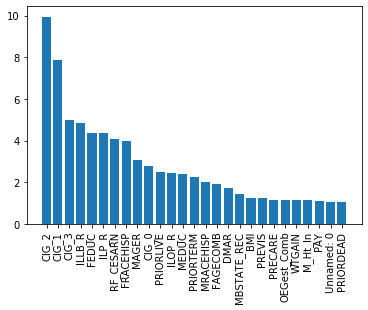

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt
cut_off=max(vif_cont[vif_cont['vif']>1].index)
plt.xticks(rotation = 90)
plt.bar(vif_cont.loc[:cut_off,'feature'],vif_cont.loc[:cut_off,'vif'])


In [123]:
features.columns

Index(['Unnamed: 0', 'MBSTATE_REC', 'MRACEHISP', 'DMAR', 'MEDUC', 'FRACEHISP',
       'FEDUC', 'PAY', 'PRECARE', 'MAGER', 'FAGECOMB', 'PRIORTERM',
       'PRIORLIVE', 'PRIORDEAD', 'ILLB_R', 'ILOP_R', 'ILP_R', 'PREVIS',
       'CIG_0', 'CIG_1', 'CIG_2', 'CIG_3', 'M_Ht_In', 'BMI', 'WTGAIN',
       'RF_CESARN', 'OEGest_Comb', 'FAGECOMB_IMP', 'ILOP_R_IMP', 'ILP_R_IMP',
       'FRACEHISP_IMP', 'FEDUC_IMP', 'MAR_P__Y', 'WIC__Y', 'RF_PDIAB__Y',
       'RF_GDIAB__Y', 'RF_PHYPE__Y', 'RF_GHYPE__Y', 'RF_EHYPE__Y',
       'RF_PPTERM__Y', 'RF_INFTR__Y', 'RF_FEDRG__Y', 'RF_ARTEC__Y',
       'RF_CESAR__Y', 'IP_GON__Y', 'IP_SYPH__Y', 'IP_CHLAM__Y', 'IP_HEPB__Y',
       'IP_HEPC__Y', 'SEX__M', 'DOB_MM__2', 'DOB_MM__3', 'DOB_MM__4',
       'DOB_MM__5', 'DOB_MM__6', 'DOB_MM__7', 'DOB_MM__8', 'DOB_MM__9',
       'DOB_MM__10', 'DOB_MM__11', 'DOB_MM__12'],
      dtype='object')

In [103]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [ ]:
import re
non_reporting_col = list(filter(lambda i: re.search('\AF_',i), qwer.columns))
impute_flag_col = list(set(list(filter(lambda i: re.search('IMP',i), qwer.columns)) + ['LMPUSED'] 
                           + list(filter(lambda i: re.search('FLG',i), qwer.columns))))
no_col = list(filter(lambda i: re.search('\ANO_',i), qwer.columns))
terr_col = ['OCTERR','OCNTYFIPS','OCNTYPOP','MBCNTRY','MRCNTRY','MRTERR','RCNTY','RCNTY_POP','RCITY_POP','RECTYPE']

In [ ]:
# Find relationship between entries flagged as 'non-reporting'
import re

non_reporting = qwer[(qwer.iloc[:,[True if re.search('\AF_',i) else False for i in qwer.columns]]==0).all(axis=1)]

print(non_reporting[non_reporting_col].sum())

for i in non_reporting.columns:
    if non_reporting[i].nunique() <2:
        print(i, non_reporting[i].nunique())

non_reporting.groupby('RESTATUS').size()

In [ ]:
# Find relationship between 'unkown or not not stated' values and wholely 'not reported' codes
no_dict = {'NO_LBRDLV':'\ALD_', 'NO_RISKS':'\ARF_', 'NO_INFEC':'\AIP_', 'NO_MMORB':'\AMM_', 
 'NO_ABNORM':'\AAB_', 'NO_CONGEN':'\ACA_'}
import re

for k in no_dict.keys():
    print(qwer[qwer[k]==9].groupby(list(filter(lambda i: re.search(no_dict[k],i), qwer.columns))).size())
    for q in list(filter(lambda i: re.search(no_dict[k],i), qwer.columns)):
        print(q, qwer[qwer[q]=='U'][k].unique())
        
print(qwer.groupby(['NO_RISKS','RF_INFTR','RF_FEDRG','RF_ARTEC']).size())
print(qwer.groupby(['NO_LBRDLV','LD_INDL']).size())

In [ ]:
list(set(non_reporting_col + impute_flag_col))

In [261]:
asdf = create_column_dictionary('UG2016.txt')

Index(['end', 'field', 'length', 'start'], dtype='object')
check after:  6 OCTERR 24 - 25
check after:  7 FILLER 24 - 31
check after:  20 MBCNTRY 80 - 81
check after:  23 MRCNTRY 85 - 86
check after:  24 FILLER 85 - 103
check after:  26 RCNTY 91 - 93
check after:  28 RCITY_POP 100 - 100


In [262]:
asdf = no_more_filler(asdf)

C:\Users\pol\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [259]:
import pandas as pd
qaz = pd.read_csv('CSV2016Territories.csv',keep_default_na=False)

C:\Users\pol\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2,7,31,36,39,47,48,54,55,56,57,58,59,60,62,63,68,69,70,71,72,73,74,75,82,84,85,86,88,112,115,126,143,144,145,150,163,166,167,173,174,177,206,231) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
u6 = create_column_dictionary('UG2016.txt')
u6 = no_more_filler(u6)
u7 = create_column_dictionary('UG2017.txt')
u7 = no_more_filler(u7)
u8 = create_column_dictionary('UG2018.txt')
u8 = no_more_filler(u8)
everything = pd.merge(pd.merge(u6,u7,how = 'outer', on = 'field', suffixes = ('_6','_7')),u8,how = 'outer', on = 'field')
everything['check'] = [everything['length_7'][i]==everything['length_6'][i]==everything['length'][i] for i in range(len(everything))]
everything[['field','length_6','length_7','length']][everything['check'] == False]

Index(['end', 'field', 'length', 'start'], dtype='object')
check after:  6 OCTERR 24 - 25
check after:  7 FILLER 24 - 31
check after:  20 MBCNTRY 80 - 81
check after:  23 MRCNTRY 85 - 86
check after:  24 FILLER 85 - 103
check after:  26 RCNTY 91 - 93
check after:  28 RCITY_POP 100 - 100
Index(['end', 'field', 'length', 'start'], dtype='object')
check after:  6 OCTERR 24 - 25
check after:  7 FILLER 24 - 31
check after:  20 MBCNTRY 80 - 81
check after:  23 MRCNTRY 85 - 86
check after:  24 FILLER 85 - 103
check after:  26 RCNTY 91 - 93
check after:  28 RCITY_POP 100 - 100
Index(['end', 'field', 'length', 'start'], dtype='object')
check after:  6 OCTERR 24 - 25
check after:  7 FILLER 24 - 31
check after:  20 FILLER 80 - 83
check after:  21 MBCNTRY 80 - 81
check after:  23 MRCNTRY 85 - 86
check after:  24 FILLER 85 - 103
check after:  26 RCNTY 91 - 93
check after:  28 RCITY_POP 100 - 100


C:\Users\pol\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,field,length_6,length_7,length
44,FBRACE,1.0,NaN,NaN
236,F_FEDUC,NaN,1.0,1.0
237,MHISPX,NaN,NaN,1.0
238,FHISPX,NaN,NaN,1.0


In [277]:
u08 = create_column_dictionary('UG2008.txt')
u08 = no_more_filler(u08)
eights = pd.merge(u08,u8,how = 'outer', on = 'field', suffixes = ('_08','_18'))
eights['check'] = [eights['length_08'][i]==eights['length_18'][i] for i in range(len(eights))]
eights[['field','length_08','length_18']][eights['check']==False].sort_values('field')
eight_non_match=eights[['field','length_08','length_18']][
    eights['check']==False].sort_values('field').reset_index().drop(columns = ['index'])
eight_non_match['split'] = [re.split('',i)[1:-1] for i in eight_non_match['field']]

Index(['end', 'field', 'length', 'start'], dtype='object')


C:\Users\pol\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [303]:
only08 = eight_non_match.loc[eight_non_match['length_08']>0][['field']].reset_index().drop(columns = ['index'])
only18 = pd.DataFrame(set(eight_non_match['field'])-set(only08.field)
                      - set(non_reporting_col) - set(impute_flag_col)-set(['DMAR'])- set(terr_col) - set(no_col),
                      columns=['field']).sort_values('field').reset_index().drop(columns = ['index'])
only08['split'] = [list(set(re.split('',i)[1:-1])) for i in only08['field']]
only18['split'] = [re.split('',i)[1:-1] for i in only18['field']]
only18['possibly'] = 0

In [279]:
only08

,field,split
0,AB_BINJ,"[B, _, I, N, A, J]"
1,CA_DOWNS,"[_, C, S, D, O, N, W, A]"
2,CIGS,"[G, S, I, C]"
3,CIG_REC6,"[E, _, C, R, I, 6, G]"
4,DFPC_IMP,"[P, F, _, C, D, I, M]"
5,DLLB_MM,"[B, L, _, D, M]"
6,DLLB_YY,"[B, L, _, Y, D]"
7,DLMP_DD,"[P, L, _, D, M]"
8,DMEDUC,"[E, C, D, U, M]"
9,DWGT,"[W, T, D, G]"


In [305]:
only18

,field,split,possibly
0,APGAR10,"[A, P, G, A, R, 1, 0]",0
1,APGAR10R,"[A, P, G, A, R, 1, 0, R]",0
2,BFED,"[B, F, E, D]",0
3,BMI,"[B, M, I]",0
4,BMI_R,"[B, M, I, _, R]",0
5,CA_DOWN,"[C, A, _, D, O, W, N]",0
6,CIG0_R,"[C, I, G, 0, _, R]",0
7,CIG1_R,"[C, I, G, 1, _, R]",0
8,CIG2_R,"[C, I, G, 2, _, R]",0
9,CIG3_R,"[C, I, G, 3, _, R]",0


In [307]:
for j in range(len(only18['field'])):
    print(j)
    temp_list = dict()
    for i in range(len(only08)):
#         print(i)
        t_sum = sum([re.search(l,only18['field'][j]) != None for l in only08['split'][i]])
        t_den = len(only18['field'][j]) + len(only08['split'][i]) - sum(
            [re.search(l,only18['field'][j]) != None for l in only08['split'][i]])
#         print(t_sum/t_den)
        if t_sum/t_den >= 0.7:
            
            temp_list[only08['field'][i]] = t_sum/t_den
    print(temp_list.keys())
    if len(temp_list.keys())>0:
        print('this', sorted(temp_list.keys(),key = temp_list.get))
        only18.loc[j,'possibly'] = sorted(temp_list.keys(),
                                          key = temp_list.get)[:4]

only18.drop(columns='split',inplace = True)

        
# only18['possibly']=[
#     [only08['field'][i],sum([re.search(l,only18['field'][j]) != None 
#                               for l in only08['split'][i]])/(len(only08['split'][i])+len(only18['split'][j])
#                                                              -sum([re.search(l,only18['field'][j]) != None 
#                                                                    for l in only08['split'][i]]))
#  for i in range(len(only08)) if sum([re.search(l,only18['field'][j]) != None 
#                                      for l in only08['split'][i]])/len(only08['split'][i])>0.7]
# for j in range(len(only18))]


0
dict_keys([])
1
dict_keys([])
2
dict_keys([])
3
dict_keys([])
4
dict_keys([])
5
dict_keys(['CA_DOWNS', 'F_UCA_DOWNS', 'UCA_DOWNS'])
this ['F_UCA_DOWNS', 'UCA_DOWNS', 'CA_DOWNS']


ValueError: Must have equal len keys and value when setting with an iterable

In [113]:
eight_non_match

,field,length_08,length_18,split
0,REVISION,1.0,NaN,"[R, E, V, I, S, I, O, N]"
1,OTERR,2.0,NaN,"[O, T, E, R, R]"
2,OCNTY,3.0,NaN,"[O, C, N, T, Y]"
3,UBFACIL,1.0,NaN,"[U, B, F, A, C, I, L]"
4,MRCNTY,3.0,NaN,"[M, R, C, N, T, Y]"
5,MBRACE,2.0,1.0,"[M, B, R, A, C, E]"
6,MRACE,2.0,NaN,"[M, R, A, C, E]"
7,MRACEREC,1.0,NaN,"[M, R, A, C, E, R, E, C]"
8,UMHISP,1.0,NaN,"[U, M, H, I, S, P]"
9,MAR,1.0,NaN,"[M, A, R]"


In [2]:
import pandas as pd
qwer = pd.read_csv('Snakelets_Final_Project\Shared\CSV2018.csv',keep_default_na=False)

C:\Users\pol\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
qwer[(qwer['ILOP_R']==888)|(qwer['ILP_R']==888)|(qwer['ILLB_R']==888)].groupby(['ILOP_R','ILP_R','ILLB_R']).size()

ILOP_R  ILP_R  ILLB_R
3       3      888           200
4       4      888            94
5       5      888           122
6       6      888           235
7       7      888           433
                          ...   
888     299    299             9
        300    300           214
        888    888       1168330
        999    999         72902
999     999    888         98578
Length: 595, dtype: int64

In [26]:
def add_random(df):
    import numpy as np
    if 'RANDOM_V' not in set(dp.columns()):
        df['RANDOM_V']=[np.random.normal for i in range(len(df))]
    else:
        print('No columns were added')
    return df

In [ ]:
import statsmodel.api as sm
import statsmodel.stats.ou

In [8]:
qwer.groupby(['ILLB_R','CA_CCHD']).size()

ILLB_R  CA_CCHD
3       N           49675
        U             127
        Y              42
4       N             381
        U               1
                    ...  
888     U            2150
        Y             763
999     N          120626
        U            1375
        Y             102
Length: 693, dtype: int64

In [ ]:
'''
vif for continuous variables to group like/correlated features
find the 'best' feature to represent these groups

stratified subpopulations to model differently

bootstrap from each target value to upscale each

stratified sampling to resemble population distribution to determine the true accuracy


'''

In [310]:
qwer.groupby(['AB_NICU','CA_CCHD']).size()

AB_NICU  CA_CCHD
N        N          3448255
         U             2042
         Y              380
U        N              949
         U             2504
Y        N           344007
         U             1561
         Y             1836
dtype: int64

In [96]:
trim_col = ['DOB_YY','DOB_MM','DOB_TT','DOB_WK','BFACIL3','MAGER9','RESTATUS','MRACEHISP','MAR_P','DMAR','MEDUC','FAGEREC11',  'FRACEHISP','FEDUC','PRIORLIVE','PRIORDEAD','PRIORTERM','LBO_REC','TBO_REC','ILLB_R11','PRECARE','PREVIS','WIC',  'CIG0_R','CIG1_R','CIG2_R','CIG3_R','BMI_R','WTGAIN_REC','RF_PDIAB','RF_GDIAB','RF_PHYPE','RF_GHYPE','RF_EHYPE',  'RF_PPTERM','RF_INFTR','RF_FEDRG','RF_ARTEC','RF_CESAR','RF_CESARN','IP_GON','IP_SYPH','IP_CHLAM','IP_HEPB','IP_HEPC',  'OB_ECVS','LD_INDL','LD_AUGM','LD_STER','LD_ANTB','LD_CHOR','LD_ANES','ME_PRES','ME_ROUT','ME_TRIAL','MM_MTR','MM_PLAC','MM_RUPT','MM_UHYST','MM_AICU','ATTEND','MTRAN','PAY_REC','APGAR5','APGAR10','DPLURAL','SEX','GESTREC10','BWTR12','AB_AVEN1','AB_AVEN6','AB_NICU','AB_SURF','AB_ANTI','AB_SEIZ','CA_ANEN','CA_MNSB','CA_CCHD','CA_CDH','CA_OMPH','CA_GAST','CA_LIMB','CA_CLEFT','CA_CLPAL','CA_DOWN','CA_DISOR','CA_HYPO','ITRAN','ILIVE','BFED']

In [95]:
qwer_trim = qwer[['DOB_YY','DOB_MM','DOB_TT','DOB_WK','BFACIL3','MAGER9','RESTATUS','MRACEHISP','MAR_P','DMAR','MEDUC','FAGEREC11',  'FRACEHISP','FEDUC','PRIORLIVE','PRIORDEAD','PRIORTERM','LBO_REC','TBO_REC','ILLB_R11','PRECARE','PREVIS','WIC',  'CIG0_R','CIG1_R','CIG2_R','CIG3_R','BMI_R','WTGAIN_REC','RF_PDIAB','RF_GDIAB','RF_PHYPE','RF_GHYPE','RF_EHYPE',  'RF_PPTERM','RF_INFTR','RF_FEDRG','RF_ARTEC','RF_CESAR','RF_CESARN','IP_GON','IP_SYPH','IP_CHLAM','IP_HEPB','IP_HEPC',  'OB_ECVS','LD_INDL','LD_AUGM','LD_STER','LD_ANTB','LD_CHOR','LD_ANES','ME_PRES','ME_ROUT','ME_TRIAL','MM_MTR','MM_PLAC','MM_RUPT','MM_UHYST','MM_AICU','ATTEND','MTRAN','PAY_REC','APGAR5','APGAR10','DPLURAL','SEX','GESTREC10','BWTR12','AB_AVEN1','AB_AVEN6','AB_NICU','AB_SURF','AB_ANTI','AB_SEIZ','CA_ANEN','CA_MNSB','CA_CCHD','CA_CDH','CA_OMPH','CA_GAST','CA_LIMB','CA_CLEFT','CA_CLPAL','CA_DOWN','CA_DISOR','CA_HYPO','ITRAN','ILIVE','BFED']]

In [100]:
qwer_antitrim = qwer[list(set(non_flags) - set(['DOB_YY','DOB_MM','DOB_TT','DOB_WK','BFACIL3','MAGER9','RESTATUS','MRACEHISP','MAR_P','DMAR','MEDUC','FAGEREC11',  'FRACEHISP','FEDUC','PRIORLIVE','PRIORDEAD','PRIORTERM','LBO_REC','TBO_REC','ILLB_R11','PRECARE','PREVIS','WIC',  'CIG0_R','CIG1_R','CIG2_R','CIG3_R','BMI_R','WTGAIN_REC','RF_PDIAB','RF_GDIAB','RF_PHYPE','RF_GHYPE','RF_EHYPE',  'RF_PPTERM','RF_INFTR','RF_FEDRG','RF_ARTEC','RF_CESAR','RF_CESARN','IP_GON','IP_SYPH','IP_CHLAM','IP_HEPB','IP_HEPC',  'OB_ECVS','LD_INDL','LD_AUGM','LD_STER','LD_ANTB','LD_CHOR','LD_ANES','ME_PRES','ME_ROUT','ME_TRIAL','MM_MTR','MM_PLAC','MM_RUPT','MM_UHYST','MM_AICU','ATTEND','MTRAN','PAY_REC','APGAR5','APGAR10','DPLURAL','SEX','GESTREC10','BWTR12','AB_AVEN1','AB_AVEN6','AB_NICU','AB_SURF','AB_ANTI','AB_SEIZ','CA_ANEN','CA_MNSB','CA_CCHD','CA_CDH','CA_OMPH','CA_GAST','CA_LIMB','CA_CLEFT','CA_CLPAL','CA_DOWN','CA_DISOR','CA_HYPO','ITRAN','ILIVE','BFED']))]

In [20]:
unknown_not_stated = {
    'DOB_TT':9999, 
    'BFACIL':9, 'BFACIL3':3, 
    'MBSTATE_REC':3, 'MHISPX':9, 'MHISP_R':9, 'MRACEHISP':8, 
    'DMAR':9, 
    'FAGEREC11':11, 'FRACE31':99, 'FRACE6':9, 'FRACE15':99, 'FHISPX':9, 'FHISP_R':9, 'FRACEHISP':9, 
    'PRIORLIVE':99,'PRIORDEAD':99, 'PRIORTERM':99, 'LBO_REC':9, 'TBO_REC':9, 
    'ILLB_R':999, 'ILLB_R11':99, 'ILOP_R':999, 'ILOP_R11':99,'ILP_R':999, 'ILP_R11':99, 
    'PRECARE':99, 'PRECARE5':5, 'PREVIS':99, 'PREVIS_REC':12, 
    'CIG_0':99, 'CIG_1':99, 'CIG_2':99, 'CIG_3':99, 'CIG0_R':6, 'CIG1_R':6, 'CIG2_R':6, 'CIG3_R':6, 'CIG_REC':'U',
    'M_Ht_In':99, 'BMI':99.9, 'BMI_R':9, 'PWgt_R':999, 'DWgt_R':999, 'WTGAIN':99, 'WTGAIN_REC':9, 
    'RF_CESARN':99, 
    'ME_PRES':9, 'ME_ROUT':9, 'DMETH_REC':9, 
    'ATTEND':9, 
    'APGAR5':99, 'APGAR5R':5, 'APGAR10':99, 'APGAR10R':5, 
    'SETORDER_R':9, 'DLMP_MM':99, 'DLMP_YY':9999, 
    'GESTREC3':3, 'OEGest_Comb':99, 'OEGest_R3':3, 
    'DBWT':9999, 'BWTR12':12, 'BWTR4':4
}

In [4]:
rc_level_18={
'facility_rc':['BFACIL','BFACIL3'],
'mommy_age_rc':['MAGER','MAGER14','MAGER9'],
'mommy_race_rc':['MRACE31','MRACE15','MRACE6','MBRACE','MHISPX','MHISP_R','MRACEHSIP'],
'papa_age_rc':['FAGECOMB','FAGEREC11'],
'papa_race_rc':['FRACE31','FRACE15','FRACE6','FHISPX','FHISP_R','FRACEHISP'],
'interv_since_lvb':['ILLB_R','ILLB_R11'],
'interv_since_othp':['ILOP_R','ILOP_R11'],
'interv_since_preg':['ILP_R','ILP_R11'],
'precare_rc':['PRECARE','PRECARE5'],
'previsits_rc':['PREVIS','PREVIS_REC'],
'cig0_rc':['CIG_0','CIG0_R'],
'cig1_rc':['CIG_1','CIG1_R'],
'cig2_rc':['CIG_2','CIG2_R'],
'cig3_rc':['CIG_3','CIG3_R'],
'bmi_rc':['BMI','BMI_R'],
'weight_gain_rc':['WTGAIN','WTGAIN_REC'],
'delivery_meth_rc':['RDMETH_REC','DMETH_REC'],
'payment_rc':['PAY','PAY_REC'],
'apgar5_rc':['APGAR5','APGAR5R'],
'apgar10_rc':['APGAR10','APGAR10R'],
'gestation_rc':['COMBGEST','GESTREC10','GESTREC3'],
'obstetric_est_rc':['OEGest_Comb','OEGest_R10','OEGest_R3'],
'babe_wt_rc':['DBWT','BWTR12','BWTR4']
}
[rc_level_18[i][0] for i in rc_level_18.keys()]
[rc_level_18[i][-1] for i in rc_level_18.keys()]

In [59]:
[rc_level_18[i][-1] for i in rc_level_18.keys()]

['BFACIL3',
 'MAGER9',
 'MRACEHSIP',
 'FAGEREC11',
 'FRACEHISP',
 'ILLB_R11',
 'ILOP_R11',
 'ILP_R11',
 'PRECARE5',
 'PREVIS_REC',
 'CIG0_R',
 'CIG1_R',
 'CIG2_R',
 'CIG3_R',
 'BMI_R',
 'WTGAIN_REC',
 'DMETH_REC',
 'PAY_REC',
 'APGAR5R',
 'APGAR10R',
 'GESTREC3',
 'OEGest_R3',
 'BWTR4']

In [45]:
qwer.groupby(['MAR_P','DMAR']).size()

MAR_P  DMAR
                456083
N      2        380559
       2           663
U      2          5163
       2            18
X      1       2003723
       1          4299
Y      2        949241
       2          1785
dtype: int64

In [54]:
[print(i, sorted(qwer[i].unique())) for i 
 in list(set(qwer.columns)-set(non_reporting_col) - set(impute_flag_col)-set(['DMAR'])- set(terr_col)) 
 if qwer[i].nunique() < 40]

CIG3_R [0, 1, 2, 3, 4, 5, 6]
ITRAN ['N', 'U', 'Y']
IP_HEPC ['N', 'U', 'Y']
MTRAN ['N', 'U', 'Y']
APGAR10R [1, 2, 3, 4, 5]
AB_NICU ['N', 'U', 'Y']
LD_STER ['N', 'U', 'Y']
BMI_R [1, 2, 3, 4, 5, 6, 9]
PRIORTERM [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 99]
WTGAIN_REC [1, 2, 3, 4, 5, 9]
RF_GDIAB ['N', 'U', 'Y']
CA_DISOR ['C', 'N', 'P', 'U']
FHISPX [0, 1, 2, 3, 4, 5, 6, 9]
LD_CHOR ['N', 'U', 'Y']
MRACE31 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
DOB_MM [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
CIG1_R [0, 1, 2, 3, 4, 5, 6]
LD_ANES ['N', 'U', 'Y']
DOB_WK [1, 2, 3, 4, 5, 6, 7]
MAGER14 [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
CA_GAST ['N', 'U', 'Y']
BFACIL3 [1, 2, 3]
COMBGEST [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 99]
OB_ECVS ['N', 'U', 'Y']
CIG0_R [0, 1, 2, 3, 4, 5, 6]
A

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [19]:
for i in unknown_not_stated.keys():
    print(i, unknown_not_stated[i], ':', len(qwer[qwer[i]==unknown_not_stated[i]]))
    if qwer[i].nunique() < 15:
        print([(j, qwer.loc[qwer[i]==j,i].count()) for j in sorted(qwer[i].unique())])

DOB_TT 9999 : 316
BFACIL 9 : 272
[(1, 3737752), (2, 21041), (3, 29512), (4, 5062), (5, 3981), (6, 596), (7, 3318), (9, 272)]
BFACIL3 3 : 272
[(1, 3737752), (2, 63510), (3, 272)]
MBSTATE_REC 3 : 7524
[(1, 2923633), (2, 870377), (3, 7524)]
MHISPX 9 : 34038
[(0, 2873599), (1, 503230), (2, 71629), (3, 23473), (4, 147561), (5, 32096), (6, 115908), (9, 34038)]
MHISP_R 9 : 34038
[(0, 2873599), (1, 503230), (2, 71629), (3, 23473), (4, 147561), (5, 148004), (9, 34038)]
MRACEHISP 8 : 34038
[(1, 1957261), (2, 552630), (3, 29115), (4, 241223), (5, 9481), (6, 83889), (7, 893897), (8, 34038)]
FAGEREC11 11 : 441149
[(1, 176), (2, 63591), (3, 407941), (4, 809107), (5, 998676), (6, 679011), (7, 265405), (8, 92027), (9, 29547), (10, 14904), (11, 441149)]
FRACE31 99 : 686911
FRACE6 9 : 686911
[(1, 2316256), (2, 473471), (3, 24493), (4, 212448), (5, 9661), (6, 78294), (9, 686911)]
FRACE15 99 : 686911
FHISPX 9 : 485408
[(0, 2533592), (1, 445139), (2, 61276), (3, 22367), (4, 119290), (5, 26808), (6, 107654)

In [53]:
qwer[list(set(qwer.columns)-set(non_reporting_col) - set(impute_flag_col)- set(terr_col))].dtypes

CIG3_R           int64
ITRAN           object
IP_HEPC         object
MTRAN           object
BMI            float64
APGAR10R         int64
AB_NICU         object
LD_STER         object
BMI_R            int64
PRIORTERM        int64
WTGAIN_REC       int64
RF_GDIAB        object
CA_DISOR        object
FHISPX           int64
LD_CHOR         object
MRACE31          int64
DOB_MM           int64
PWgt_R           int64
CIG1_R           int64
LD_ANES         object
DOB_WK           int64
MAGER14          int64
CA_GAST         object
CIG_2            int64
BFACIL3          int64
COMBGEST         int64
OB_ECVS         object
CIG0_R           int64
AB_ANTI         object
MM_MTR          object
CA_CLEFT        object
AB_SEIZ         object
NO_LBRDLV        int64
NO_CONGEN        int64
RF_INFTR        object
PAY              int64
FRACE15          int64
NO_MMORB         int64
LD_AUGM         object
WTGAIN           int64
DBWT             int64
RF_CESAR        object
RDMETH_REC       int64
DOB_YY     

In [43]:
qwer.loc[qwer['DMAR']=='',list(set(qwer.columns)-set(non_reporting_col) - set(impute_flag_col)- set(terr_col))]

,CIG3_R,ITRAN,IP_HEPC,MTRAN,BMI,APGAR10R,AB_NICU,LD_STER,BMI_R,PRIORTERM,WTGAIN_REC,RF_GDIAB,CA_DISOR,FHISPX,LD_CHOR,MRACE31,DOB_MM,PWgt_R,CIG1_R,LD_ANES,DOB_WK,MAGER14,CA_GAST,CIG_2,BFACIL3,COMBGEST,OB_ECVS,CIG0_R,AB_ANTI,MM_MTR,CA_CLEFT,AB_SEIZ,NO_LBRDLV,NO_CONGEN,RF_INFTR,PAY,FRACE15,NO_MMORB,LD_AUGM,WTGAIN,DBWT,RF_CESAR,RDMETH_REC,DOB_YY,DMETH_REC,CIG_REC,FEDUC,RF_PPTERM,WIC,M_Ht_In,BWTR12,PRECARE,RF_PHYPE,MHISP_R,AB_AVEN6,PREVIS_REC,OEGest_Comb,ME_PRES,ILP_R,MRACEHISP,AB_SURF,MM_RUPT,PRIORDEAD,IP_CHLAM,CA_OMPH,GESTREC10,LD_INDL,BWTR4,MM_UHYST,CA_DOWN,IP_HEPB,CIG_0,CA_ANEN,APGAR5,FHISP_R,APGAR10,CA_LIMB,BFACIL,SETORDER_R,PREVIS,MBRACE,MRACE15,PRECARE5,ME_TRIAL,MM_AICU,APGAR5R,CA_CCHD,PAY_REC,OB_ECVF,PRIORLIVE,CA_CDH,RF_CESARN,BFED,DLMP_MM,TBO_REC,DWgt_R,MAGER9,MAR_P,MRACE6,MM_PLAC,RF_FEDRG,FRACE31,MBSTATE_REC,ILOP_R11,ILOP_R,RF_ARTEC,GESTREC3,CIG_1,MHISPX,MEDUC,RF_GHYPE,ME_ROUT,CA_CLPAL,FAGEREC11,RF_EHYPE,ATTEND,DMAR,ILLB_R,ILIVE,NO_INFEC,RESTATUS,f_RF_INFT,LD_ANTB,RF_PDIAB,ILP_R11,LBO_REC,DLMP_YY,DOB_TT,FRACE6,CA_HYPO,FAGECOMB,OEGest_R3,f_FEDUC,MAGER,CA_MNSB,AB_AVEN1,FRACEHISP,ILLB_R11,OEGest_R10,SEX,CIG2_R,IP_GON,IP_SYPH,NO_RISKS,CIG_3,DPLURAL,NO_ABNORM
184130,0,N,N,N,20.5,5,N,N,2,0,4,N,N,0,N,4,1,127,0,Y,2,9,N,0,1,41,N,0,N,N,N,N,0,1,N,3,5,1,Y,37,3696,N,1,2018,1,N,6,N,N,66,8,1,N,0,N,11,41,1,888,4,N,N,0,N,N,9,N,3,N,N,N,0,N,9,0,88,N,1,9,20,4,5,1,X,N,4,N,3,N,0,N,0,U,3,1,164,4,,4,N,X,4,2,88,888,X,2,0,0,4,N,1,N,4,N,1,,888,Y,1,1,1,Y,N,88,1,2017,222,4,N,29,2,1,29,N,N,4,88,9,M,0,N,N,1,0,1,1
184131,0,N,N,N,19.2,5,N,N,2,0,3,N,N,0,N,1,1,126,0,Y,2,10,N,0,1,40,N,0,N,N,N,N,0,1,N,2,1,1,N,25,3185,N,1,2018,1,N,7,N,N,68,7,2,N,0,N,7,40,1,28,1,N,N,0,N,N,8,N,3,N,N,N,0,N,9,0,88,N,1,9,11,1,1,1,X,N,4,N,2,N,1,N,0,U,3,2,151,5,,1,N,X,1,2,88,888,X,2,0,0,7,N,1,N,6,N,1,,28,Y,1,1,1,N,N,4,2,2017,555,1,N,38,2,1,33,N,N,1,4,8,F,0,N,N,1,0,1,1
184132,0,N,N,N,30.1,5,N,N,4,0,5,N,N,9,N,1,1,170,0,Y,2,11,N,0,1,38,N,0,N,N,N,N,0,1,N,1,99,1,N,49,3062,N,1,2018,1,N,9,N,N,63,7,3,Y,1,N,7,38,1,129,7,N,N,0,N,N,6,Y,3,N,N,N,0,N,8,9,88,N,1,9,12,1,1,1,X,N,3,N,1,N,4,N,0,U,4,5,219,6,,1,N,X,99,1,88,888,X,2,0,1,4,N,1,N,11,N,1,,129,Y,1,1,1,N,N,8,5,2017,1153,9,N,99,2,1,39,N,N,8,8,6,F,0,N,N,0,0,1,1
184133,0,N,N,N,35.5,5,N,N,5,0,3,N,N,9,N,1,1,207,0,Y,3,10,N,0,1,40,N,0,N,N,N,N,0,1,N,2,99,1,N,26,3420,N,1,2018,1,N,9,N,N,64,7,2,N,9,N,7,40,1,59,8,N,N,0,N,N,8,N,3,N,N,N,0,N,9,9,88,N,1,9,12,1,1,1,X,N,4,N,2,N,1,N,0,U,3,2,233,5,,1,N,X,99,1,88,888,X,2,0,9,9,N,1,N,6,N,1,,59,Y,1,1,1,N,N,6,2,2017,504,9,N,37,2,1,33,N,N,8,6,8,M,0,N,N,1,0,1,1
184134,0,N,N,N,23.5,5,N,N,2,0,3,N,N,0,N,1,1,150,0,Y,2,10,N,0,1,39,N,0,N,N,N,N,0,1,N,2,1,1,N,27,3629,N,1,2018,1,N,6,N,N,67,8,3,N,1,N,7,39,1,888,7,N,N,0,N,N,7,N,3,N,N,N,0,N,9,0,88,N,1,9,12,1,1,1,X,N,4,N,2,N,0,N,0,U,4,1,177,5,,1,N,X,1,1,88,888,X,2,0,1,6,N,1,N,6,N,1,,888,Y,1,1,1,N,N,88,1,2017,1218,1,N,38,2,1,34,N,N,1,88,7,F,0,N,N,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640208,0,N,N,N,27.4,5,N,N,3,0,4,N,N,0,N,2,5,170,0,N,3,9,N,0,2,40,N,0,N,N,N,N,1,1,N,1,2,1,N,40,3686,N,1,2018,1,N,4,N,N,66,8,5,N,0,N,12,40,1,22,2,N,N,0,N,N,8,N,3,N,N,N,0,N,99,0,99,N,5,9,99,2,2,2,X,N,5,N,1,N,1,N,0,U,8,2,210,4,,2,N,X,2,1,88,888,X,2,0,0,4,N,1,N,4,N,5,,22,Y,1,2,1,N,N,3,2,2017,1040,2,N,28,2,1,26,N,N,2,3,8,F,0,N,N,1,0,1,1
640209,0,N,N,N,26.0,5,N,N,3,1,3,N,N,1,N,1,9,142,0,N,3,11,N,0,2,42,N,0,N,N,N,N,1,1,N,3,1,1,N,28,3544,N,1,2018,1,N,4,N,N,62,8,2,N,0,N,8,41,1,12,1,N,N,0,N,N,10,N,3,N,N,N,0,N,10,1,88,N,5,9,14,1,1,1,X,N,4,N,3,N,2,N,0,U,12,4,170,6,

In [295]:
qwer.groupby(['GESTREC10','OEGest_R10']).size()

GESTREC10  OEGest_R10
1          1               1110
           2                308
           3                 12
           4                  1
2          1                176
           2              21080
           3               1624
           4                356
           5                737
           6                621
           7                268
           8                 75
           9                  5
3          1                 21
           2               1821
           3              27310
           4               3083
           5               3381
           6               3837
           7               3610
           8               1453
           9                321
           10                15
4          1                  3
           2                 69
           3               2563
           4              32134
           5               9086
           6               6694
           7               4283
           8      

In [290]:
qwer.groupby(['TBO_REC','PRIORLIVE','PRIORDEAD','PRIORTERM']).size()

TBO_REC  PRIORLIVE  PRIORDEAD  PRIORTERM
1        0          0          0            1168330
2        0          0          1             193485
                    1          0               4099
         1          0          0             865849
3        0          0          2              51339
                                             ...   
9        99         99         5                  5
                               6                  1
                               9                  2
                               10                 2
                               99              6702
Length: 1089, dtype: int64

In [281]:
qwer[(qwer['CIG_REC']=='U') & (qwer['CIG0_R']!=6)].count()
# .groupby(['CIG_0','CIG0_R']).size()

DOB_YY          673
DOB_MM          673
DOB_TT          673
DOB_WK          673
OCTERR          673
OCNTYFIPS       673
OCNTYPOP        673
BFACIL          673
F_FACILITY      673
BFACIL3         673
MAGE_IMPFLG     673
MAGE_REPFLG     673
MAGER           673
MAGER14         673
MAGER9          673
MBCNTRY         673
MBSTATE_REC     673
MRCNTRY         673
MRTERR          673
RCNTY           673
RCNTY_POP       673
RCITY_POP       673
RECTYPE         673
RESTATUS        673
MRACE31         673
MRACE6          673
MRACE15         673
MBRACE          673
MRACEIMP        673
MHISPX          673
MHISP_R         673
F_MHISP         673
MRACEHISP       673
MAR_P           673
DMAR            673
MAR_IMP         673
F_MAR_P         673
MEDUC           673
F_MEDUC         673
FAGERPT_FLG     673
FAGECOMB        673
FAGEREC11       673
FRACE31         673
FRACE6          673
FRACE15         673
FHISPX          673
FHISP_R         673
F_FHISP         673
FRACEHISP       673
FEDUC           673


In [282]:
qwer[qwer['PRIORLIVE']==99].groupby(['PRIORLIVE','PRIORDEAD','PRIORTERM']).size()

PRIORLIVE  PRIORDEAD  PRIORTERM
99         0          0             241
                      1              70
                      2              20
                      3              14
                      4               3
                      6               3
                      99             56
           1          0              14
                      1               8
                      3               1
                      5               1
                      99              9
           2          0               5
                      1               2
                      3               2
           3          0               3
                      1               2
                      3               1
           4          0               1
           5          0               1
           6          0               1
           9          1               1
                      99              2
           99         0             218
        

In [229]:
qwer.groupby(['DMAR','MAR_IMP']).size()

DMAR  MAR_IMP
1.0   1.0         314
2.0   1.0        1681
dtype: int64

In [226]:
import numpy as np
len(qwer[qwer['DMAR']==1])

2008022

In [209]:
len(qwer)

3801534

In [202]:
sorted(qwer['MHISPX'].unique())

[0, 1, 2, 3, 4, 5, 6, 9]

In [176]:
qwer.groupby(['DPLURAL','SETORDER_R']).size()

DPLURAL  SETORDER_R
1        9             3674115
2        1               62018
         2               61826
         9                  23
3        1                1155
         2                1142
         3                1129
         9                   1
4        1                  28
         2                  29
         3                  29
         4                  28
         9                   1
5        1                   2
         2                   2
         3                   2
         4                   2
         5                   2
dtype: int64

In [203]:
pearson_corr = qwer_trim.corr()

In [232]:
pearson_corr

,DOB_MM,DOB_TT,DOB_WK,BFACIL3,MAGER9,RESTATUS,MRACEHISP,MEDUC,FAGEREC11,FRACEHISP,FEDUC,PRIORLIVE,PRIORDEAD,PRIORTERM,LBO_REC,TBO_REC,ILLB_R11,PRECARE,PREVIS,CIG0_R,CIG1_R,CIG2_R,CIG3_R,BMI_R,WTGAIN_REC,RF_CESARN,ME_PRES,ME_ROUT,ATTEND,PAY_REC,APGAR5,APGAR10,DPLURAL,GESTREC10,BWTR12
DOB_MM,1.000000,-0.000595,0.001113,-0.002208,0.006355,0.003834,0.007978,-0.000715,0.008401,0.005537,-0.001595,-0.001879,0.000307,-0.000916,-0.001048,0.000128,0.002779,-0.001845,0.000254,-0.003856,-0.002623,-0.001875,-0.001942,0.007673,-0.008827,-0.002259,-0.001211,-0.000867,0.001720,0.006246,0.000970,0.002208,-0.000705,-0.003490,-0.004109
DOB_TT,-0.000595,1.000000,-0.017899,-0.015048,-0.012787,0.006699,-0.006821,0.003133,-0.004418,-0.004504,0.001218,0.002636,0.009331,0.007565,-0.025097,-0.021821,0.042137,-0.000426,0.003983,0.004696,0.003502,0.003209,0.002464,0.009594,0.008275,-0.002148,0.003533,-0.015641,-0.011288,0.001380,0.000966,-0.000022,0.005875,0.007091,-0.000674
DOB_WK,0.001113,-0.017899,1.000000,-0.003430,-0.000119,0.000188,-0.000580,0.002472,0.003668,0.003632,0.005059,-0.000979,0.000322,0.000592,-0.007343,-0.006747,0.012267,0.001618,0.003122,-0.000353,-0.000361,-0.000068,-0.000873,0.005461,0.003876,-0.003741,-0.001062,-0.006505,0.001269,0.000629,-0.001526,-0.001005,0.000975,-0.001292,-0.006673
BFACIL3,-0.002208,-0.015048,-0.003430,1.000000,0.025579,-0.015222,-0.044468,-0.001713,-0.007704,-0.047149,-0.013782,0.055280,0.043267,0.042841,0.084503,0.068843,-0.040186,0.008876,-0.010506,-0.006482,-0.000113,0.003553,0.002570,-0.022711,0.025430,0.043264,0.056054,-0.084058,0.425068,0.128255,0.260237,0.020617,-0.018215,0.097594,0.054664
MAGER9,0.006355,-0.012787,-0.000119,0.025579,1.000000,0.006297,-0.063647,0.377683,0.222098,-0.152263,0.099024,0.087085,0.003653,0.027668,0.296047,0.315520,-0.234830,-0.015479,0.022653,-0.068093,-0.049752,-0.039847,-0.031178,0.024208,-0.013660,0.027532,0.022834,0.123080,-0.022911,0.143866,0.004588,0.007815,0.047701,-0.028568,0.040959
RESTATUS,0.003834,0.006699,0.000188,-0.015222,0.006297,1.000000,-0.129868,0.050950,-0.026510,-0.114390,-0.000625,-0.003141,0.000646,0.004408,-0.014906,-0.008475,0.011124,0.008435,0.006728,0.029978,0.024637,0.022439,0.025263,0.004797,0.009653,0.005977,0.003010,0.024807,-0.016302,0.057372,-0.014085,-0.014214,0.027553,-0.012220,-0.014033
MRACEHISP,0.007978,-0.006821,-0.000580,-0.044468,-0.063647,-0.129868,1.000000,-0.213219,-0.006425,0.561749,-0.135299,0.016714,0.002776,0.000712,0.047046,0.020924,-0.021606,0.012601,-0.015918,-0.104643,-0.086514,-0.075681,-0.054449,0.037639,-0.068472,0.011286,0.004539,0.000793,-0.032175,-0.071165,0.006349,0.012472,-0.023292,-0.002413,-0.033643
MEDUC,-0.000715,0.003133,0.002472,-0.001713,0.377683,0.050950,-0.213219,1.000000,-0.044164,-0.305507,0.329762,-0.042251,0.006522,0.003231,-0.180770,-0.150317,0.088336,-0.025970,0.038502,-0.145104,-0.127785,-0.114896,-0.094210,-0.094888,0.070046,-0.001938,0.010701,0.031972,-0.014462,0.229769,0.000842,0.012241,0.030965,0.026975,0.070669
FAGEREC11,0.008401,-0.004418,0.003668,-0.007704,0.222098,-0.026510,-0.006425,-0.044164,1.000000,0.424003,0.628513,0.055543,0.011865,0.024373,0.161652,0.167601,-0.089399,0.035265,-0.002059,0.091161,0.097616,0.094566,0.085739,0.052941,-0.004531,0.022581,0.012130,0.047561,-0.025014,-0.056830,0.010725,-0.018860,0.023450,-0.017758,-0.065235
FRACEHISP,0.005537,-0.004504,0.003632,-0.047149,-0.152263,-0.114390,0.561749,-0.305507,0.424003,1.000000,0.238198,0.028016,0.008874,0.010109,0.072019,0.052407,-0.016305,0.035439,-0.017662,0.023523,0.033809,0.035251,0.038408,0.067719,-0.048048,0.017933,0.006038,-0.003718,-0.031791,-0.144778,0.009334,-0.006240,-0.016550,-0.008837,-0.086770


In [225]:
pearson_corr = pearson_corr.dropna(how = 'all').dropna(axis = 1, how = 'all')

In [241]:
min_lim = 0.5
for i in range(len(pearson_corr)):
    for j in range(i):
        if pearson_corr.iloc[i,j] > min_lim:
            print(pearson_corr.index[i],
                  pearson_corr.columns[j],
                  pearson_corr.iloc[i,j])

FRACEHISP MRACEHISP 0.5617489417479972
FEDUC FAGEREC11 0.6285134376319775
PRIORDEAD PRIORLIVE 0.7850782580593686
PRIORTERM PRIORLIVE 0.656070789952022
PRIORTERM PRIORDEAD 0.6891748016148693
TBO_REC LBO_REC 0.8625399247843947
PREVIS PRECARE 0.6806902445253401
CIG1_R CIG0_R 0.8776361450161564
CIG2_R CIG0_R 0.8257618875747426
CIG2_R CIG1_R 0.9407936859700614
CIG3_R CIG0_R 0.646566739095661
CIG3_R CIG1_R 0.7371873081447747
CIG3_R CIG2_R 0.78224205716018


In [270]:
sorted(list(qwer_antitrim.columns))

['APGAR10R',
 'APGAR5R',
 'BFACIL',
 'BMI',
 'BWTR4',
 'CIG_0',
 'CIG_1',
 'CIG_2',
 'CIG_3',
 'CIG_REC',
 'COMBGEST',
 'COMPGST_IMP',
 'DBWT',
 'DLMP_MM',
 'DLMP_YY',
 'DMETH_REC',
 'FAGECOMB',
 'FAGERPT_FLG',
 'FHISPX',
 'FHISP_R',
 'FRACE15',
 'FRACE31',
 'FRACE6',
 'F_AB_ANTIBIO',
 'F_AB_NIUC',
 'F_AB_SEIZ',
 'F_AB_SURFAC',
 'F_AB_VENT',
 'F_AB_VENT6',
 'F_APGAR5',
 'F_BFED',
 'F_CA_ANEN',
 'F_CA_CHROM',
 'F_CA_CLEFT',
 'F_CA_CLEFTLP',
 'F_CA_DOWNS',
 'F_CA_GASTRO',
 'F_CA_HEART',
 'F_CA_HERNIA',
 'F_CA_HYPOS',
 'F_CA_LIMB',
 'F_CA_MENIN',
 'F_CA_OMPHA',
 'F_CIGS_0',
 'F_CIGS_1',
 'F_CIGS_2',
 'F_CIGS_3',
 'F_DMETH_REC',
 'F_DWGT',
 'F_FACILITY',
 'F_FHISP',
 'F_IP_CHLAM',
 'F_IP_GONOR',
 'F_IP_HEPATB',
 'F_IP_HEPATC',
 'F_IP_SYPH',
 'F_LD_ANES',
 'F_LD_ANTB',
 'F_LD_AUGM',
 'F_LD_CHOR',
 'F_LD_INDL',
 'F_LD_STER',
 'F_MAR_P',
 'F_MEDUC',
 'F_ME_PRES',
 'F_ME_ROUT',
 'F_ME_TRIAL',
 'F_MHISP',
 'F_MM_',
 'F_MM_AICU',
 'F_MM_MTR',
 'F_MM_RUPT',
 'F_MM_UHYST',
 'F_MPCB',
 'F_M_HT',
 '

In [271]:
sorted(list(qwer_trim.columns))


['AB_ANTI',
 'AB_AVEN1',
 'AB_AVEN6',
 'AB_NICU',
 'AB_SEIZ',
 'AB_SURF',
 'APGAR10',
 'APGAR5',
 'ATTEND',
 'BFACIL3',
 'BFED',
 'BMI_R',
 'BWTR12',
 'CA_ANEN',
 'CA_CCHD',
 'CA_CDH',
 'CA_CLEFT',
 'CA_CLPAL',
 'CA_DISOR',
 'CA_DOWN',
 'CA_GAST',
 'CA_HYPO',
 'CA_LIMB',
 'CA_MNSB',
 'CA_OMPH',
 'CIG0_R',
 'CIG1_R',
 'CIG2_R',
 'CIG3_R',
 'DMAR',
 'DOB_MM',
 'DOB_TT',
 'DOB_WK',
 'DOB_YY',
 'DPLURAL',
 'FAGEREC11',
 'FEDUC',
 'FRACEHISP',
 'GESTREC10',
 'ILIVE',
 'ILLB_R11',
 'IP_CHLAM',
 'IP_GON',
 'IP_HEPB',
 'IP_HEPC',
 'IP_SYPH',
 'ITRAN',
 'LBO_REC',
 'LD_ANES',
 'LD_ANTB',
 'LD_AUGM',
 'LD_CHOR',
 'LD_INDL',
 'LD_STER',
 'MAGER9',
 'MAR_P',
 'MEDUC',
 'ME_PRES',
 'ME_ROUT',
 'ME_TRIAL',
 'MM_AICU',
 'MM_MTR',
 'MM_PLAC',
 'MM_RUPT',
 'MM_UHYST',
 'MRACEHISP',
 'MTRAN',
 'OB_ECVS',
 'PAY_REC',
 'PRECARE',
 'PREVIS',
 'PRIORDEAD',
 'PRIORLIVE',
 'PRIORTERM',
 'RESTATUS',
 'RF_ARTEC',
 'RF_CESAR',
 'RF_CESARN',
 'RF_EHYPE',
 'RF_FEDRG',
 'RF_GDIAB',
 'RF_GHYPE',
 'RF_INFTR',
 'RF_PD

In [277]:
list(qwer.columns)

['DOB_YY',
 'DOB_MM',
 'DOB_TT',
 'DOB_WK',
 'BFACIL',
 'F_FACILITY',
 'BFACIL3',
 'MAGE_IMPFLG',
 'MAGE_REPFLG',
 'MAGER',
 'MAGER14',
 'MAGER9',
 'MBSTATE_REC',
 'RESTATUS',
 'MRACE31',
 'MRACE6',
 'MRACE15',
 'MBRACE',
 'MRACEIMP',
 'MHISPX',
 'MHISP_R',
 'F_MHISP',
 'MRACEHISP',
 'MAR_P',
 'DMAR',
 'MAR_IMP',
 'F_MAR_P',
 'MEDUC',
 'F_MEDUC',
 'FAGERPT_FLG',
 'FAGECOMB',
 'FAGEREC11',
 'FRACE31',
 'FRACE6',
 'FRACE15',
 'FHISPX',
 'FHISP_R',
 'F_FHISP',
 'FRACEHISP',
 'FEDUC',
 'PRIORLIVE',
 'PRIORDEAD',
 'PRIORTERM',
 'LBO_REC',
 'TBO_REC',
 'ILLB_R',
 'ILLB_R11',
 'ILOP_R',
 'ILOP_R11',
 'ILP_R',
 'ILP_R11',
 'PRECARE',
 'F_MPCB',
 'PRECARE5',
 'PREVIS',
 'PREVIS_REC',
 'F_TPCV',
 'WIC',
 'F_WIC',
 'CIG_0',
 'CIG_1',
 'CIG_2',
 'CIG_3',
 'CIG0_R',
 'CIG1_R',
 'CIG2_R',
 'CIG3_R',
 'F_CIGS_0',
 'F_CIGS_1',
 'F_CIGS_2',
 'F_CIGS_3',
 'CIG_REC',
 'F_TOBACO',
 'F_M_HT',
 'BMI',
 'BMI_R',
 'F_PWGT',
 'F_DWGT',
 'WTGAIN',
 'WTGAIN_REC',
 'F_WTGAIN',
 'RF_PDIAB',
 'RF_GDIAB',
 'RF_PHYPE

In [231]:
pearson_corr.iloc[i,j]

0.025578521401895603

In [91]:
qaz['DMAR'].nunique() >2

False

In [99]:
skewed = pd.DataFrame([(i, qaz[i].skew()) for i in qaz.columns 
              if (qaz[i].dtype  == 'int64' and qaz[i].nunique()>5)],columns=['name','skew']).sort_values('skew')
skewed

,name,skew
56,APGAR10,-7.956474
30,ILOP_R,-1.724649
31,ILOP_R11,-1.716209
63,BWTR12,-0.794126
5,MAGER14,-0.627670
36,PREVIS_REC,-0.240939
62,DBWT,-0.223420
2,DOB_WK,0.028547
0,DOB_MM,0.192981
6,MAGER9,0.248880


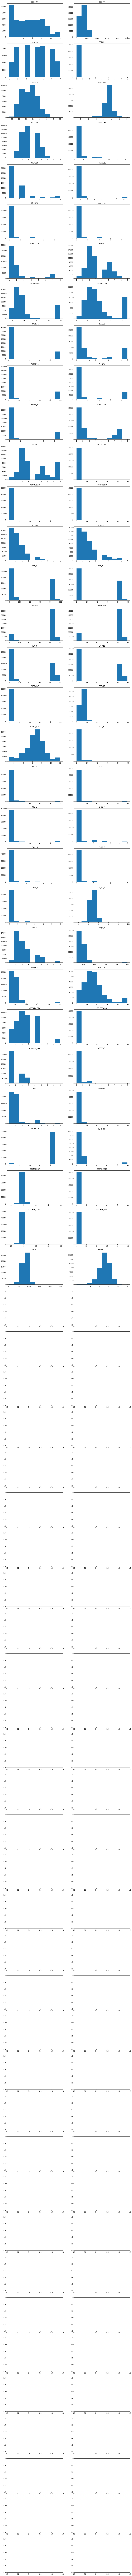

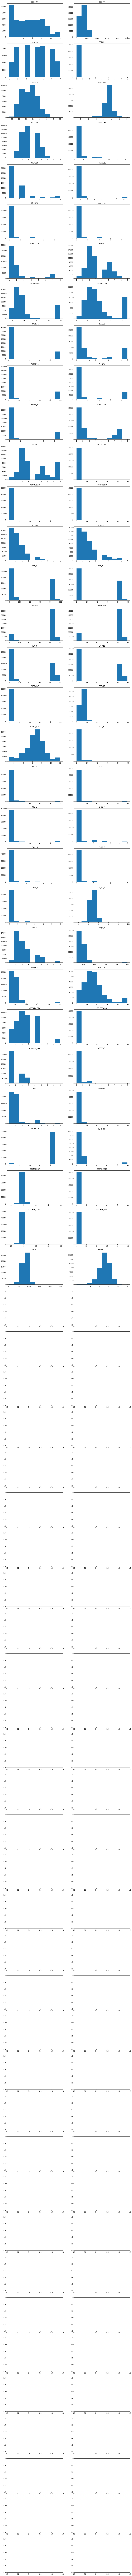

In [130]:
import matplotlib.pyplot as plt

updown = len(skewed['name'])
fig, ax = plt.subplots(updown, 2, squeeze = False, figsize = (15, updown *5))
for i in range(updown):
#     print(i)
#     print(skewed['name'][i])
    ax[i//2,i%2].hist(qaz[skewed['name'][i]])
    ax[i//2,i%2].title.set_text(skewed['name'][i])
fig

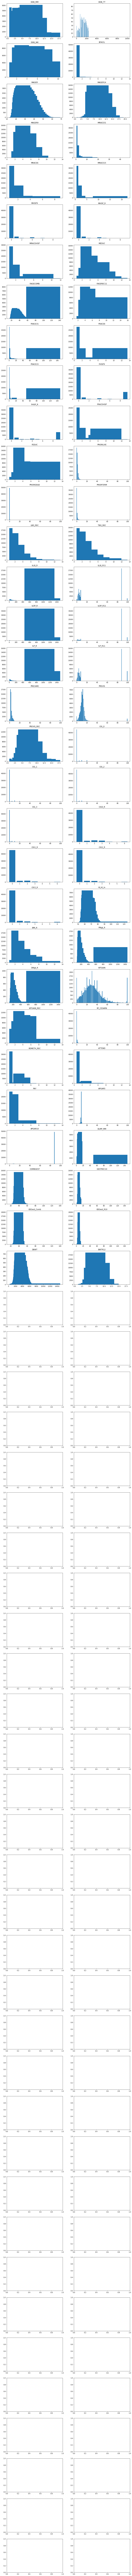

In [177]:
import matplotlib.pyplot as plt

updown = len(skewed['name'])
fig, ax = plt.subplots(updown, 2, squeeze = False, figsize = (15, updown *5))
for i in range(updown):
#     print(i)
#     print(skewed['name'][i])
#     print(qaz[skewed['name'][i]].groupby(qaz[skewed['name'][i]]).count())
    ax[i//2,i%2].bar(x = qaz[skewed['name'][i]].groupby(qaz[skewed['name'][i]]).unique(),height = qaz[skewed['name'][i]].groupby(qaz[skewed['name'][i]]).count())
    ax[i//2,i%2].title.set_text(skewed['name'][i])
# fig
# plt.bar()

In [ ]:
def comp_bxcxed_graph(xTr,yTr):
    from scipy.special import boxcox1p
    import matplotlib.pyplot as plt

    non_nominal = pd.Series(list(set(ordinal_columns) | set(numerical_columns)), name = 'Feature')

    lm = LinearRegression()
    relevance = pd.DataFrame(columns = ['Feature','Rsq'])
    for colnum in range(0,len(xTr.columns)):
        col = xTr.columns[colnum]
        lm.fit(xTr[[col]],yTr)
        relevance.loc[colnum,'Feature'] = col
        relevance.loc[colnum,'Rsq'] = lm.score(xTr[[col]],yTr)
        
    residual = pd.DataFrame(columns = relevance['Feature'])
    these_resids = pd.merge(relevance['Feature'],non_nominal,how = 'inner')

    leftright = 2
    updownmax = 25
    updown = updownmax if len(to_boxcox) > updownmax else len(to_boxcox)//leftright

    fig, ax = plt.subplots(updown, leftright,squeeze = False,figsize = (15,updown * 5))
    for i in range(updown):
        for j in range(leftright):
            if j%2 ==0:
                lm.fit(xTr[[to_boxcox[i]]],yTr)
                ax[i, j].scatter(x = lm.predict(xTr[[to_boxcox[i]]]),
                                 y = yTr - lm.predict(xTr[[to_boxcox[i]]]))
                ax[i, j].title.set_text(to_boxcox[i])
            else:
                xTrbc = pd.DataFrame(boxcox(xTr[[to_boxcox[i]]] + 1)[0])
                lm.fit(xTrbc,yTr)
                ax[i, j].scatter(x = lm.predict(xTrbc),
                                 y = yTr - lm.predict(xTrbc))

    fig

In [89]:
non_flags = list(set(qwer.columns)-set(list(filter(lambda i: re.search('\AF_',i) ,qwer.columns))))